# Sequential Neural Posterior Estimation (SNPE)

**Session 4, Part 3** - Hands-on exercise (~20 min)

In the previous notebook, we saw that **NPE struggled** with the Lotka-Volterra problem while **NLE performed well**. The issue: NPE must learn accurate posteriors across the entire prior space, but the true posterior is sharply concentrated.

**Solution: Sequential NPE (SNPE)** - Focus simulations where the posterior has mass!

## 1. Recap: The Problem with Amortized NPE

With standard (amortized) NPE:

```
Sample θ from PRIOR → Simulate x → Train
```

**Problem:** Most prior samples produce observations far from $x_o$!
- Wasted simulations in irrelevant regions
- Poor posterior approximation where it matters
- Need many simulations to cover the whole prior space

### The Sequential Idea

```
Round 1: Sample θ from PRIOR      → Simulate → Train → Get rough posterior
Round 2: Sample θ from POSTERIOR₁ → Simulate → Train → Get better posterior  
Round 3: Sample θ from POSTERIOR₂ → Simulate → Train → Get refined posterior
...
```

Each round **focuses simulations** on the region where the posterior has mass!

## 2. The SNPE API in `sbi`

The key pattern is a **loop** where each round:
1. Samples from the current `proposal` (prior in round 1, posterior in later rounds)
2. Simulates data for those parameters
3. Trains the density estimator
4. Builds a new posterior and sets it as the next proposal

### Key Functions

**Initialization:**
```python
from sbi.inference import SNPE, simulate_for_sbi

trainer = SNPE(prior)
proposal = prior  # Start with prior
```

**Data generation** (works with any proposal - prior or posterior):
```python
theta, x = simulate_for_sbi(simulator, proposal, num_simulations, num_workers=NUM_WORKERS)
```

**Training** (must tell SNPE where samples came from):
```python
trainer.append_simulations(theta, x, proposal=proposal)  # proposal argument is crucial!
trainer.train()
```

**Building posterior and updating proposal:**
```python
posterior = trainer.build_posterior()
proposal = posterior.set_default_x(x_o)  # Makes posterior usable as next proposal
```

**Key insight:** `posterior.set_default_x(x_o)` conditions the posterior on your observation, so when `simulate_for_sbi` samples from it, you get θ values that are likely given $x_o$!

In [1]:
import matplotlib.pyplot as plt
import torch
from functools import partial

from sbi.inference import SNPE, simulate_for_sbi
from sbi.analysis import pairplot

from simulators import (
    create_lotka_volterra_prior,
    generate_observed_data,
    lotka_volterra_simulator,
)

## 3. Setup

In [2]:
# Configuration
NUM_ROUNDS = 3
NUM_SIMS_PER_ROUND = 2000
NUM_WORKERS = 4  # Adjust based on your machine
USE_AUTOCORRELATION = True

print(f"Total simulations: {NUM_ROUNDS * NUM_SIMS_PER_ROUND}")
print(f"(Compare to 20,000 for amortized NPE in the previous notebook)")

Total simulations: 6000
(Compare to 20,000 for amortized NPE in the previous notebook)


In [3]:
# Setup prior, simulator, and observation
prior = create_lotka_volterra_prior()
x_o, theta_true = generate_observed_data(use_autocorrelation=USE_AUTOCORRELATION)

simulator = partial(lotka_volterra_simulator, use_autocorrelation=USE_AUTOCORRELATION)

print(f"True parameters: {theta_true.numpy()}")
print(f"Observation shape: {x_o.shape}")

True parameters: [0.1  0.02 0.01 0.1 ]
Observation shape: torch.Size([1, 20])


## 4. Exercise: Implement Multi-Round SNPE

**Your task:** Complete the SNPE training loop below.

For each round, you need to:
1. Generate training data using `simulate_for_sbi` with the current `proposal`
2. Append simulations to the trainer (don't forget the `proposal` argument!)
3. Train the density estimator
4. Build the posterior and store it
5. **Crucially:** Update the `proposal` for the next round using `set_default_x(x_o)`

**Hint:** Look at the API section above for the key function calls.

In [4]:
# Initialize
trainer = SNPE(prior)
proposal = prior  # Start sampling from the prior
posteriors = []   # Store posteriors from each round

for round_idx in range(NUM_ROUNDS):
    print(f"\n=== Round {round_idx + 1} ===")
    
    # TODO Step 1: Generate training data by sampling from the proposal
    # Use simulate_for_sbi(simulator, proposal, NUM_SIMS_PER_ROUND, num_workers=NUM_WORKERS)
    print(f"Simulating {NUM_SIMS_PER_ROUND} samples...")
    theta, x = simulate_for_sbi(simulator, proposal, NUM_SIMS_PER_ROUND, num_workers=NUM_WORKERS)
    
    # TODO Step 2: Append simulations to trainer
    # Important: pass proposal=proposal so SNPE knows where samples came from
    trainer.append_simulations(theta, x, proposal=proposal)
    
    # TODO Step 3: Train
    print("Training...")
    trainer.train(show_train_summary=True)
    
    # TODO Step 4: Build posterior and store it
    posterior = trainer.build_posterior()
    posteriors.append(posterior)
    
    # TODO Step 5: Update proposal for next round
    # Use posterior.set_default_x(x_o) to condition on our observation
    proposal = posterior.set_default_x(x_o)
    
    # Quick check (this part is complete)
    samples = posterior.sample((1000,), x=x_o)
    print(f"Posterior mean: {samples.mean(dim=0).numpy()}")
    print(f"Posterior std:  {samples.std(dim=0).numpy()}")

print("\n=== Done ===")


=== Round 1 ===
Simulating 2000 samples...


  0%|          | 0/2000 [00:00<?, ?it/s]

Training...
 Neural network successfully converged after 326 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 326
        Best validation performance: -22.0233
        -------------------------
        


  0%|          | 0/1000 [00:00<?, ?it/s]

Posterior mean: [0.10314951 0.02040217 0.00973135 0.09533259]
Posterior std:  [0.00439571 0.00046002 0.00037228 0.00301986]

=== Round 2 ===
Simulating 2000 samples...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Training...
Using SNPE-C with atomic loss
 Neural network successfully converged after 97 epochs.
        -------------------------
        ||||| ROUND 2 STATS |||||:
        -------------------------
        Epochs trained: 97
        Best validation performance: 0.0220
        -------------------------
        


  0%|          | 0/1000 [00:00<?, ?it/s]

Posterior mean: [0.10132216 0.02022415 0.00994434 0.09874959]
Posterior std:  [0.00121203 0.0002515  0.00014648 0.00141865]

=== Round 3 ===
Simulating 2000 samples...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Training...
Using SNPE-C with atomic loss
 Neural network successfully converged after 53 epochs.
        -------------------------
        ||||| ROUND 3 STATS |||||:
        -------------------------
        Epochs trained: 53
        Best validation performance: 0.0801
        -------------------------
        


  0%|          | 0/1000 [00:00<?, ?it/s]

Posterior mean: [0.10083414 0.02000458 0.00986147 0.09819398]
Posterior std:  [0.00086689 0.00020376 0.00011288 0.00105423]

=== Done ===


### Solution

<details>
<summary>Click to reveal solution</summary>

```python
theta, x = simulate_for_sbi(simulator, proposal, NUM_SIMS_PER_ROUND, num_workers=NUM_WORKERS)
trainer.append_simulations(theta, x, proposal=proposal)
trainer.train(show_train_summary=True)
posterior = trainer.build_posterior()
proposal = posterior.set_default_x(x_o)
```

</details>

## 5. Sample from Final Posterior

In [5]:
# Get samples from each round for comparison
samples_r1 = posteriors[0].sample((5000,), x=x_o)
samples_r2 = posteriors[1].sample((5000,), x=x_o)
snpe_samples = posteriors[2].sample((10000,), x=x_o)

print(f"Final SNPE posterior mean: {snpe_samples.mean(dim=0).numpy()}")
print(f"Final SNPE posterior std:  {snpe_samples.std(dim=0).numpy()}")
print(f"True parameters:           {theta_true.numpy()}")

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Final SNPE posterior mean: [0.10084595 0.0200078  0.00986248 0.09819395]
Final SNPE posterior std:  [0.00086689 0.00020267 0.00010908 0.00101473]
True parameters:           [0.1  0.02 0.01 0.1 ]


## 6. Visualize: Posterior Evolution Across Rounds

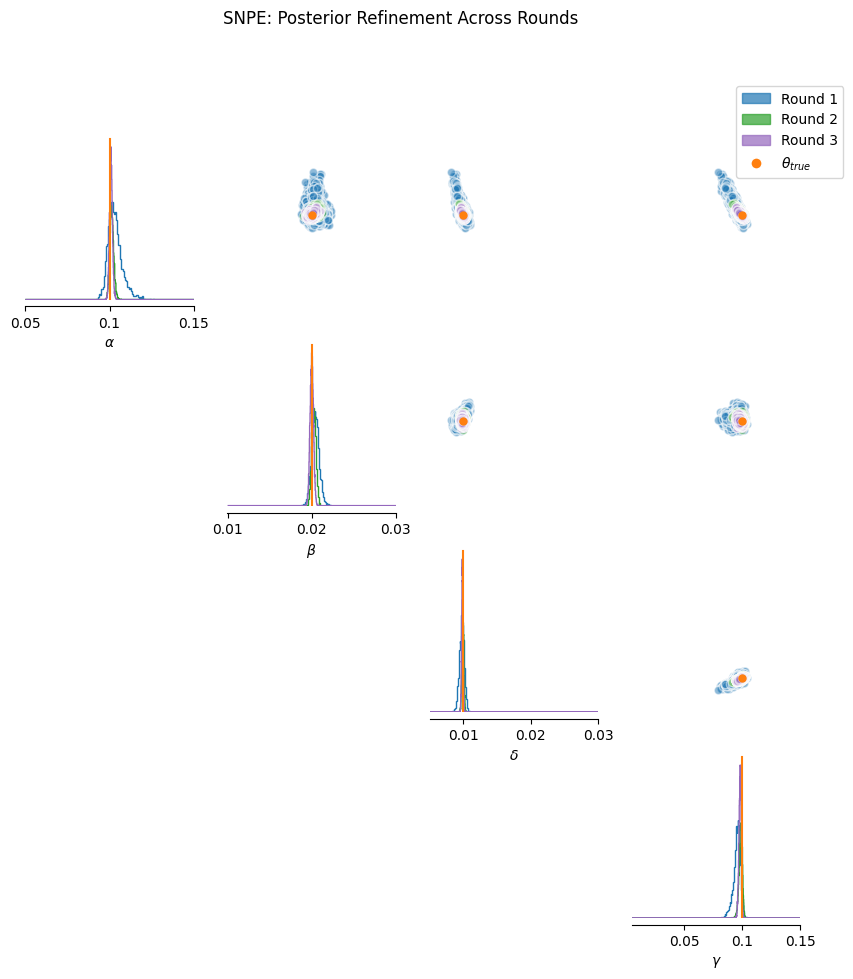

In [6]:
from matplotlib.patches import Patch

param_names = [r"$\alpha$", r"$\beta$", r"$\delta$", r"$\gamma$"]
prior_limits = [[prior.base_dist.low.numpy()[i], prior.base_dist.high.numpy()[i]] for i in range(4)]

fig, ax = pairplot(
    [samples_r1, samples_r2, snpe_samples],
    limits=prior_limits,
    labels=param_names,
    points=theta_true.unsqueeze(0),
    upper="scatter",
)

# Manual legend
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend_handles = [
    Patch(facecolor=colors[0], edgecolor=colors[0], alpha=0.7, label='Round 1'),
    Patch(facecolor=colors[2], edgecolor=colors[2], alpha=0.7, label='Round 2'),
    Patch(facecolor=colors[4], edgecolor=colors[4], alpha=0.7, label='Round 3'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[1], markersize=8, label=r'$\theta_{true}$'),
]
fig.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(0.95, 0.95), fontsize=10)
plt.suptitle("SNPE: Posterior Refinement Across Rounds", y=1.02)
plt.show()

## 7. Compare: SNPE vs NPE vs NLE

In [7]:
# Load NPE and NLE samples from previous notebook
import os

if os.path.exists('npe_nle_samples.pt'):
    saved_data = torch.load('npe_nle_samples.pt')
    npe_samples = saved_data['npe_samples']
    nle_samples = saved_data['nle_samples']
    print("Loaded NPE and NLE samples from nb_04")
else:
    print("Warning: 'npe_nle_samples.pt' not found. Run nb_04 first!")
    print("Using placeholder values for comparison.")
    npe_samples = None
    nle_samples = None

Loaded NPE and NLE samples from nb_04


/var/folders/8b/twrk9drd50l015by37329_7m0000gn/T/ipykernel_9310/493518389.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_data = torch.load('npe_nle_samples.pt')


In [8]:
# Quantitative comparison
print("Posterior Standard Deviations Comparison")
print("=" * 65)
print(f"{'Parameter':<10} {'True':>10} {'SNPE (6k)':>12} {'NPE (20k)':>12} {'NLE (20k)':>12}")
print("-" * 65)

for i, name in enumerate(["alpha", "beta", "delta", "gamma"]):
    true_val = theta_true[i].item()
    snpe_std = snpe_samples[:, i].std().item()
    npe_std = npe_samples[:, i].std().item() if npe_samples is not None else float('nan')
    nle_std = nle_samples[:, i].std().item() if nle_samples is not None else float('nan')
    print(f"{name:<10} {true_val:>10.4f} {snpe_std:>12.4f} {npe_std:>12.4f} {nle_std:>12.4f}")

print("-" * 65)
print(f"\nSNPE used only {NUM_ROUNDS * NUM_SIMS_PER_ROUND} simulations vs 20,000 for NPE/NLE!")

Posterior Standard Deviations Comparison
Parameter        True    SNPE (6k)    NPE (20k)    NLE (20k)
-----------------------------------------------------------------
alpha          0.1000       0.0009       0.0041       0.0015
beta           0.0200       0.0002       0.0002       0.0002
delta          0.0100       0.0001       0.0003       0.0001
gamma          0.1000       0.0010       0.0033       0.0010
-----------------------------------------------------------------

SNPE used only 6000 simulations vs 20,000 for NPE/NLE!


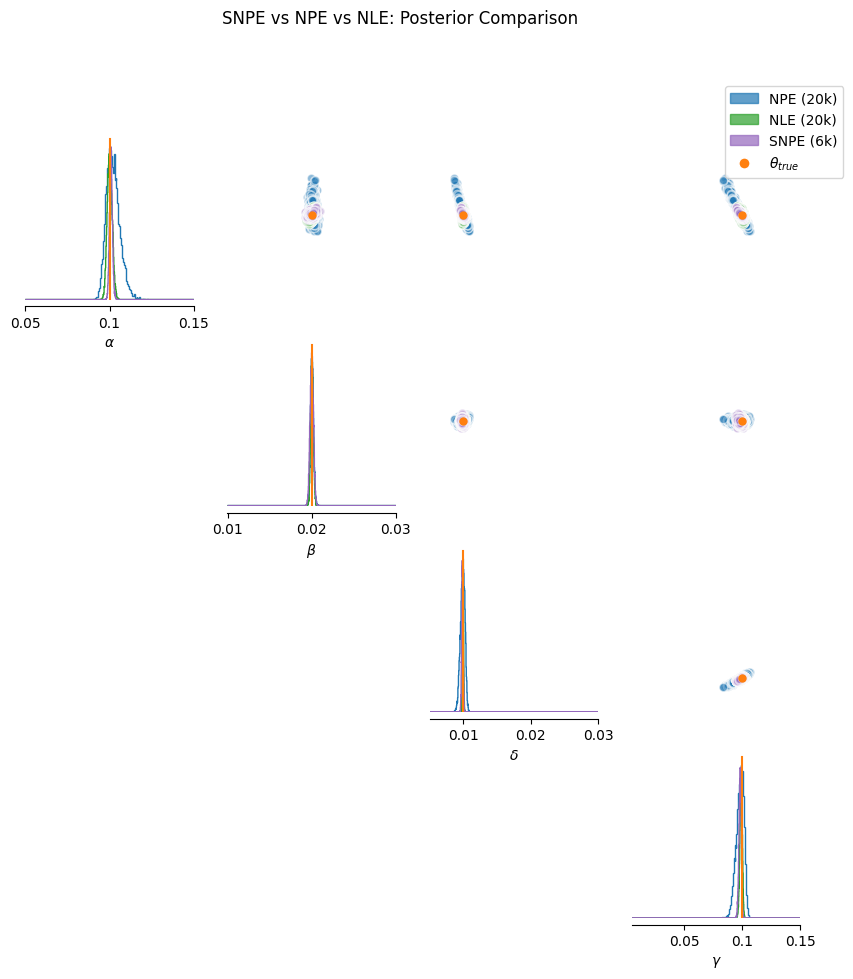

In [9]:
# Visual comparison: SNPE vs NPE vs NLE posteriors
if npe_samples is not None and nle_samples is not None:
    fig, ax = pairplot(
        [npe_samples, nle_samples, snpe_samples],
        limits=prior_limits,
        labels=param_names,
        points=theta_true.unsqueeze(0),
        upper="scatter",
    )
    
    # Manual legend
    legend_handles = [
        Patch(facecolor=colors[0], edgecolor=colors[0], alpha=0.7, label='NPE (20k)'),
        Patch(facecolor=colors[2], edgecolor=colors[2], alpha=0.7, label='NLE (20k)'),
        Patch(facecolor=colors[4], edgecolor=colors[4], alpha=0.7, label='SNPE (6k)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[1], markersize=8, label=r'$\theta_{true}$'),
    ]
    fig.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(0.95, 0.95), fontsize=10)
    plt.suptitle("SNPE vs NPE vs NLE: Posterior Comparison", y=1.02)
    plt.show()

## 8. Posterior Predictive Check

Let's validate SNPE by checking if simulations from posterior samples match the observed data.

In [10]:
import numpy as np
from simulators import simulate

# Generate predictive time series from SNPE posterior
n_predictive = 50
time = np.arange(0, 200, 0.1)

# Observed time series
ts_observed = simulate(theta_true.numpy())

# SNPE predictive time series
snpe_predictive_theta = snpe_samples[:n_predictive]
ts_snpe = [simulate(snpe_predictive_theta[i].numpy()) for i in range(n_predictive)]

# NPE and NLE predictive (if available)
if npe_samples is not None:
    npe_predictive_theta = npe_samples[:n_predictive]
    ts_npe = [simulate(npe_predictive_theta[i].numpy()) for i in range(n_predictive)]
if nle_samples is not None:
    nle_predictive_theta = nle_samples[:n_predictive]
    ts_nle = [simulate(nle_predictive_theta[i].numpy()) for i in range(n_predictive)]

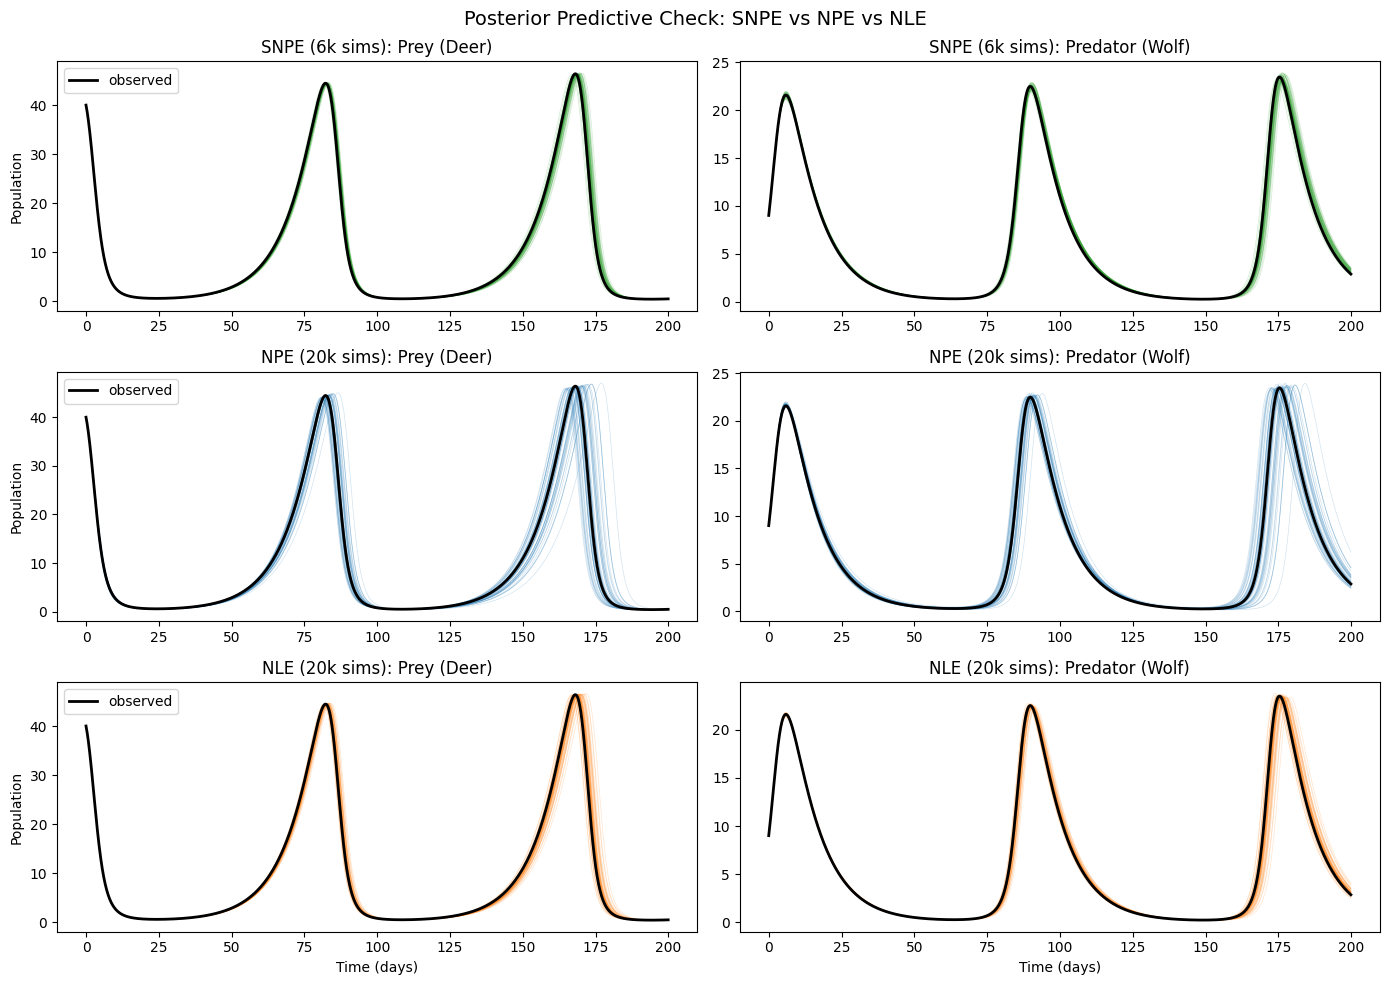

In [11]:
# Compare predictive time series: SNPE vs NPE vs NLE
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# SNPE predictive
ax = axes[0, 0]
for ts in ts_snpe:
    ax.plot(time, ts[:, 0], color="C2", alpha=0.2, linewidth=0.5)
ax.plot(time, ts_observed[:, 0], color="k", linewidth=2, label="observed")
ax.set_ylabel("Population")
ax.set_title("SNPE (6k sims): Prey (Deer)")
ax.legend()

ax = axes[0, 1]
for ts in ts_snpe:
    ax.plot(time, ts[:, 1], color="C2", alpha=0.2, linewidth=0.5)
ax.plot(time, ts_observed[:, 1], color="k", linewidth=2)
ax.set_title("SNPE (6k sims): Predator (Wolf)")

# NPE predictive
if npe_samples is not None:
    ax = axes[1, 0]
    for ts in ts_npe:
        ax.plot(time, ts[:, 0], color="C0", alpha=0.2, linewidth=0.5)
    ax.plot(time, ts_observed[:, 0], color="k", linewidth=2, label="observed")
    ax.set_ylabel("Population")
    ax.set_title("NPE (20k sims): Prey (Deer)")
    ax.legend()

    ax = axes[1, 1]
    for ts in ts_npe:
        ax.plot(time, ts[:, 1], color="C0", alpha=0.2, linewidth=0.5)
    ax.plot(time, ts_observed[:, 1], color="k", linewidth=2)
    ax.set_title("NPE (20k sims): Predator (Wolf)")

# NLE predictive
if nle_samples is not None:
    ax = axes[2, 0]
    for ts in ts_nle:
        ax.plot(time, ts[:, 0], color="C1", alpha=0.2, linewidth=0.5)
    ax.plot(time, ts_observed[:, 0], color="k", linewidth=2, label="observed")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Population")
    ax.set_title("NLE (20k sims): Prey (Deer)")
    ax.legend()

    ax = axes[2, 1]
    for ts in ts_nle:
        ax.plot(time, ts[:, 1], color="C1", alpha=0.2, linewidth=0.5)
    ax.plot(time, ts_observed[:, 1], color="k", linewidth=2)
    ax.set_xlabel("Time (days)")
    ax.set_title("NLE (20k sims): Predator (Wolf)")

plt.suptitle("Posterior Predictive Check: SNPE vs NPE vs NLE", fontsize=14)
plt.tight_layout()
plt.show()

## 9. Discussion

### What We Learned

| Method | Simulations | Posterior Quality | Amortized? |
|--------|-------------|-------------------|------------|
| NPE | 20,000 | Wider (struggled) | Yes |
| NLE | 20,000 | Tight, accurate | Partial |
| **SNPE** | **6,000** | Tight, accurate | No |

### SNPE Trade-offs

**Advantages:**
- Much more simulation-efficient for a specific observation
- Can achieve tight posteriors even when amortized NPE struggles
- Iteratively improves the posterior estimate

**Disadvantages:**
- **Not amortized**: Must re-run for each new observation
- Requires multiple training rounds (more wall-clock time)
- Need to choose number of rounds and simulations per round

### When to Use SNPE?

1. **Expensive simulations**: Each simulation counts, can't afford 100k+ samples
2. **Sharp posteriors**: Amortized NPE would need too many simulations
3. **Single observation**: You have one $x_o$ and need the best possible posterior
4. **Prior is broad**: Large prior-to-posterior contraction

## 10. Summary

### The Sequential SBI Family

| Method | What it learns | Sequential variant |
|--------|---------------|-------------------|
| NPE | $p(\theta|x)$ | **SNPE** |
| NLE | $p(x|\theta)$ | SNLE |
| NRE | $p(x|\theta)/p(x)$ | SNRE |

All sequential methods follow the same principle: **focus simulations where they matter**.

### Key Takeaways

1. **Sequential methods are simulation-efficient** - Important when simulations are expensive
2. **Trade-off: efficiency vs amortization** - SNPE gives better posteriors but only for one $x_o$
3. **SNPE can rescue NPE** - When amortized NPE struggles with sharp posteriors
4. **Choose based on your use case**:
   - Many observations, cheap simulations → NPE
   - One observation, expensive simulations → SNPE
   - Sharp posteriors, need MCMC flexibility → NLE/SNLE

---

**Congratulations!** You've now seen the main SBI methods:
- ABC (Session 2)
- NPE with neural density estimators (Sessions 2-3)
- NLE with MCMC (Session 4)
- SNPE for simulation efficiency (Session 4)

You're ready for the **hackathon**! Apply these methods to your own problems.